Modeling
---

We are attempting to predict a continuous variable. I will try the following models:

1. Lasso Linear Regression
2. Gradient Boosted Lasso
3. Random Forest

In [359]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from sklearn import linear_model, preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import logistic, uniform, randint

import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool

import warnings
warnings.filterwarnings('ignore')

We made train/test splits in the previous step, but for the life of me I can't figure out why.

Let's just get all our data in here, then run cross validation on all of them with new splits.

In [360]:
total_set = pd.read_json('../data/Step 3 - Total Set.json', orient='records')

train_set = total_set[total_set['set']=='train']

X_master = train_set.drop(['set', 'SalePrice'], axis=1)

y = train_set['SalePrice']

test_set = total_set[total_set['set'] == 'test']

Doing some last-minute feature selection.

In [361]:
all_X_cols = X_master.columns

In [362]:
%store -r usable_cats

hot_cats = []

for cat in usable_cats :
    for col in all_X_cols :
        if cat in col :
            hot_cats.append(col)


In [363]:
best_numerics = ['OverallQual',
 'GrLivArea',
 'ExterQual',
 'KitchenQual',
 'BsmtQual',
 'GarageArea',
 'TotalBsmtSF',
 'FullBath',
 'YearBuilt',
 'GarageFinish',
 'YearRemodAdd']

In [364]:
usable_cols = []

usable_cols.extend(hot_cats)
usable_cols.extend(best_numerics)

In [365]:
X = X_master[usable_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Lasso
---

For comparison, I'll grid search for optimal alpha and then compare to the result of Bayesian optimization.

In [366]:
# Finding optimal alpha by grid search.

model = Lasso(max_iter=100000)

param_ranges = {
    "alpha" : np.logspace(-30, 2, num=1000, base=10)
}

gscv_lasso = RandomizedSearchCV(model, param_ranges, scoring='r2', cv=5, n_jobs=-1)

gscv_lasso.fit(X, y)

rscv_alpha = gscv_lasso.best_params_['alpha']

# best_alpha
gscv_lasso.best_params_

{'alpha': 1.1118496048192745}

In [370]:
# Finding optimal alpha by Bayesian optimization.

param_bounds = {"alpha":(0, 100)}

def Lasso_eval(alpha) :
    params = {"alpha":alpha}

    model = Lasso(max_iter=100000, **params)

    score = cross_val_score(model, X, y, cv=5).mean()

    return score

optimal = BayesianOptimization(Lasso_eval, param_bounds, verbose=False, allow_duplicate_points=True)

optimal.maximize(60, 60)

print(optimal.max)

bayes_alpha = optimal.max['params']['alpha']

{'target': 0.8050729498241058, 'params': {'alpha': 85.59069318895351}}


Interesting discrepancy.

Now I'll get 30 R2 scores for this model to help create a generalized comparison between all my models.

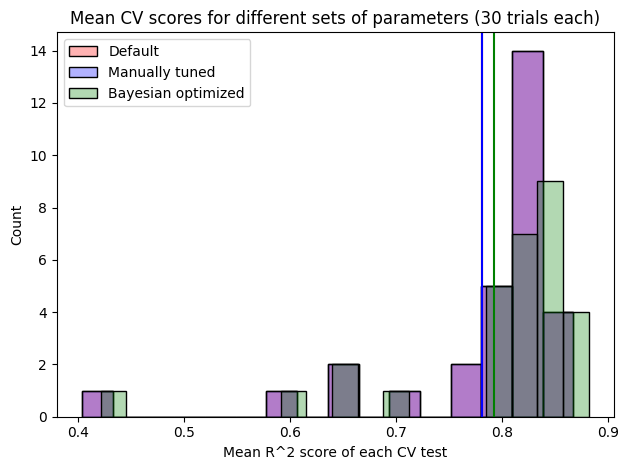

In [383]:
default = []
tuned = []
bayesian = []

for i in range(30) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = Lasso()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    default.append(r2_score(y_test, y_pred))

    model = Lasso(max_iter=10000, alpha=rscv_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tuned.append(r2_score(y_test, y_pred))

    model = Lasso(max_iter=10000, alpha=bayes_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bayesian.append(r2_score(y_test, y_pred))

default_lasso = np.array(default)
tuned_lasso = np.array(tuned)
bayesian_lasso = np.array(bayesian)

sns.histplot(default_lasso, alpha=0.3, color='red', bins='auto', common_norm=True, label='Default')
sns.histplot(tuned_lasso, alpha=0.3, color='blue', bins='auto', common_norm=True, label='Manually tuned')
sns.histplot(bayesian_lasso, alpha=0.3, color='green', bins='auto', common_norm=True, label='Bayesian optimized')
plt.axvline(x=default_lasso.mean(), color='red')
plt.axvline(x=tuned_lasso.mean(), color='blue')
plt.axvline(x=bayesian_lasso.mean(), color='green')
plt.legend()
plt.title('Mean CV scores for different sets of parameters (30 trials each)')
plt.xlabel('Mean R^2 score of each CV test')
plt.tight_layout()
plt.show()

It appears that 1 is indeed the default value of alpha, so the manually tuned and default versions are identical.

It also seems that increasing alpha got marginally better scores without changing the shape of the distribution, including its quirks. That's interesting!

However, the results themselves vary from decent to atrocious. This is most likely due to an oversight in a previous step (ie, outlier handling, feature selection, etc). I will refer to this as "the problem" throughout this notebook.

Gradient Boosted
---

As before, I'll start by manually tuning some parameters, then comparing them to the Bayesian version.

I'll run a couple grid searches on this first set of parameter ranges for extra surety.

In [286]:
model = GradientBoostingRegressor()

param_ranges = {
    'n_estimators': list(range(10, 200)),
    'learning_rate': np.linspace(0.01, 0.4, 20),
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

rscv_gb = RandomizedSearchCV(model, param_ranges, n_iter=200, cv=5, n_jobs=-1, random_state=1)

rscv_gb.fit(X, y)

best_gb_params_1 = rscv_gb.best_params_

print(best_gb_params_1)

###

model = GradientBoostingRegressor()

param_ranges = {
    'n_estimators': list(range(10, 200)),
    'learning_rate': np.linspace(0.01, 0.4, 20),
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

rscv_gb = RandomizedSearchCV(model, param_ranges, n_iter=200, cv=5, n_jobs=-1, random_state=2)

rscv_gb.fit(X, y)

best_gb_params_2 = rscv_gb.best_params_

print(best_gb_params_2)

{'subsample': 1.0, 'n_estimators': 151, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.07157894736842105}
{'subsample': 0.9, 'n_estimators': 185, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.11263157894736842}


Now I'll use those results to adjust the ranges and check again.

In [287]:
model = GradientBoostingRegressor()

param_ranges = {
    'n_estimators': list(range(100, 200)),
    'learning_rate': np.linspace(0.06, 0.15, 20),
    'max_depth': [2, 3, 4],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0, 1.1]
}

rscv_gb = RandomizedSearchCV(model, param_ranges, n_iter=200, cv=5, n_jobs=-1, random_state=3)

rscv_gb.fit(X, y)

best_gb_params_3 = rscv_gb.best_params_

print(best_gb_params_3)

{'subsample': 0.9, 'n_estimators': 157, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.06947368421052631}


Etc

In [288]:
model = GradientBoostingRegressor()

param_ranges = {
    'n_estimators': list(range(140, 170)),
    'learning_rate': np.linspace(0.05, 0.1, 20),
    'max_depth': [4],
    'min_samples_split': [20, 25, 30],
    'min_samples_leaf': [2],
    'subsample': [0.9, 1]
}

rscv_gb = RandomizedSearchCV(model, param_ranges, n_iter=100, cv=5, n_jobs=-1, random_state=4)

rscv_gb.fit(X, y)

best_gb_params_4 = rscv_gb.best_params_

print(best_gb_params_4)

{'subsample': 0.9, 'n_estimators': 143, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.052631578947368425}


And so forth

In [289]:
model = GradientBoostingRegressor()

param_ranges = {
    'n_estimators': list(range(135, 155)),
    'learning_rate': np.linspace(.02, .06),
    'max_depth': [4],
    'min_samples_split': [16, 18, 20, 22, 24],
    'min_samples_leaf': [2],
    'subsample': [0.9]
}

rscv_gb = RandomizedSearchCV(model, param_ranges, n_iter=100, cv=5, n_jobs=-1, random_state=5)

rscv_gb.fit(X, y)

best_gb_params_5 = rscv_gb.best_params_

print(best_gb_params_5)

{'subsample': 0.9, 'n_estimators': 149, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.053469387755102044}


In [375]:
manually_tuned_gb_params = {
    'n_estimators': 150,
    'learning_rate': 0.053,
    'max_depth': 4,
    'min_samples_split': 20,
    'min_samples_leaf': 2,
    'subsample': 0.9
}

Now I'll find a set of params using Bayesian optimization.

In [376]:
param_bounds = param_ranges = {
    'n_estimators': (50, 300),
    'learning_rate': (0.01, 1),
    'max_depth': (2, 15),
    'min_samples_split': (2, 30),
    'min_samples_leaf': (1, 5),
    'subsample': (0.5, 1),
}

def GB_eval(n_estimators, learning_rate, max_depth, min_samples_split, \
            min_samples_leaf, subsample) :
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'subsample': subsample
    }

    model = GradientBoostingRegressor(**params)

    score = cross_val_score(model, X, y, cv=5).mean()

    return score

optimal = BayesianOptimization(GB_eval, param_bounds, verbose=False)

optimal.maximize(60, 60)

print(optimal.max)

bayes_gb_params = {}

float_parameters = ['learning_rate', 'subsample']

for key, value in optimal.max['params'].items() :
    if key in float_parameters :
        bayes_gb_params[key] = value
    else:
        bayes_gb_params[key] = int(round(value, 0))

bayes_gb_params

{'target': 0.8770036361117202, 'params': {'learning_rate': 0.08190604102279775, 'max_depth': 2.0, 'min_samples_leaf': 2.9680018374857675, 'min_samples_split': 9.226776392668341, 'n_estimators': 263.88720666804625, 'subsample': 1.0}}


{'learning_rate': 0.08190604102279775,
 'max_depth': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'n_estimators': 264,
 'subsample': 1.0}

Now let's compare our performances.

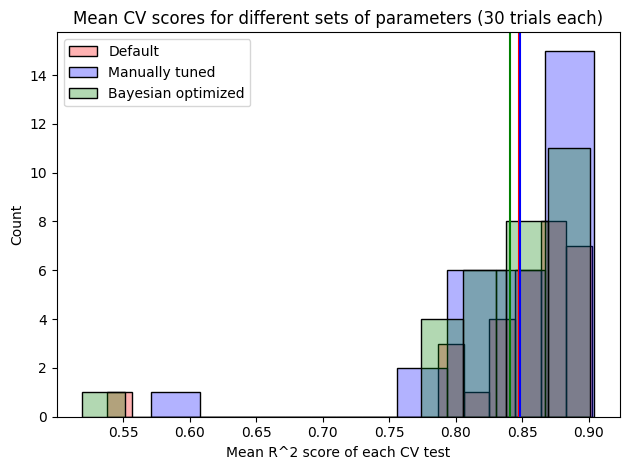

In [378]:
default = []
tuned = []
bayes = []

for i in range(30) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model_default = GradientBoostingRegressor()
    model_default.fit(X_train, y_train)
    y_pred = model_default.predict(X_test)
    default.append(r2_score(y_test, y_pred))

    model_manual = GradientBoostingRegressor(**manually_tuned_gb_params)
    model_manual.fit(X_train, y_train)
    y_pred = model_manual.predict(X_test)
    tuned.append(r2_score(y_test, y_pred))

    model_bayes = GradientBoostingRegressor(**bayes_gb_params)
    model_bayes.fit(X_train, y_train)
    y_pred = model_bayes.predict(X_test)
    bayes.append(r2_score(y_test, y_pred))

default_gb = np.array(default)
tuned_gb = np.array(tuned)
bayesian_gb = np.array(bayes)


sns.histplot(default_gb, alpha=0.3, color='red', bins='auto', common_norm=True, label='Default')
sns.histplot(tuned_gb, alpha=0.3, color='blue', bins='auto', common_norm=True, label='Manually tuned')
sns.histplot(bayesian_gb, alpha=0.3, color='green', bins='auto', common_norm=True, label='Bayesian optimized')
plt.axvline(x=default_gb.mean(), color='red')
plt.axvline(x=tuned_gb.mean(), color='blue')
plt.axvline(x=bayesian_gb.mean(), color='green')
plt.legend()
plt.title('Mean CV scores for different sets of parameters (30 trials each)')
plt.xlabel('Mean R^2 score of each CV test')
plt.tight_layout()
plt.show()

It's troubling that tuning the parameters didn't help appreciably. It's also fun that each model has one atrocious score each; could it be that these are all on the same split? If so, it would support our idea that "the problem" in the underlying data affects our results more than our model parameters, and the splits themselves explain most of the variance.

In [379]:
bad_day = np.where(default_gb < 0.65)

print(default_gb[bad_day])
print(tuned_gb[bad_day])
print(bayesian_gb[bad_day])

[0.53738643]
[0.57078982]
[0.51928294]


That is indeed the case. "The problem" exists in the data in such a way that these models can't overcome that variance.

Be that as it may, let's continue with this modeling step for now, and seek to solve "the problem" after the process is complete.

Random Forest
---

Since this is my first solo exploration of modeling, I'm going to do my best to manually select optimal parameters. My method will be to arbitrarily select a range for each parameter and then run/score the model repeatedly, manually moving or shrinking the parameter ranges with each iteration until I'm confident that I've found their optimal values.

In [185]:
model = RandomForestRegressor()

param_ranges = {
    'n_estimators': list(range(10, 200)),
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': list(range(5, 20)),
    'n_jobs': [-1]
}

rscv_rf = RandomizedSearchCV(model, param_ranges, n_iter=500, cv=5, n_jobs=-1, random_state=1)

rscv_rf.fit(X, y)

best_rf_params1 = rscv_rf.best_params_

best_rf_params1

{'n_jobs': -1,
 'n_estimators': 158,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 6,
 'max_depth': 5}

In [134]:
model = RandomForestRegressor()

param_ranges = {
    'n_estimators': list(range(10, 200)),
    'max_depth': [4, 5, 6],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [15, 20, 25, 30, 35, 40],
    'n_jobs': [-1]
}

rscv_rf = RandomizedSearchCV(model, param_ranges, n_iter=500, cv=5, n_jobs=-1, random_state=2)

rscv_rf.fit(X, y)

best_rf_params2 = rscv_rf.best_params_

best_rf_params2

c:\Users\Josh\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Josh\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'n_jobs': -1,
 'n_estimators': 28,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 40,
 'max_depth': 6}

In [66]:
model = RandomForestRegressor()

param_ranges = {
    'n_estimators': list(range(10, 200)),
    'max_depth': list(range(5, 15)),
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': list(range(4, 11)),
    'n_jobs': [-1]
}

rscv_rf = RandomizedSearchCV(model, param_ranges, n_iter=500, cv=5, n_jobs=-1, random_state=3)

rscv_rf.fit(X, y)

best_rf_params3 = rscv_rf.best_params_

best_rf_params3

c:\Users\Josh\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'n_jobs': -1,
 'n_estimators': 154,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 5,
 'max_depth': 13}

In [67]:
model = RandomForestRegressor()

param_ranges = {
    'n_estimators': list(range(10, 200)),
    'max_depth': list(range(5, 15)),
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': list(range(4, 11)),
    'n_jobs': [-1]
}

rscv_rf = RandomizedSearchCV(model, param_ranges, n_iter=500, cv=5, n_jobs=-1, random_state=4)

rscv_rf.fit(X, y)

best_rf_params4 = rscv_rf.best_params_

best_rf_params4

c:\Users\Josh\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'n_jobs': -1,
 'n_estimators': 134,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 14}

In [68]:
model = RandomForestRegressor()

param_ranges = {
    'n_estimators': list(range(120, 170)),
    'max_depth': list(range(12, 16)),
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [1],
    'max_features': list(range(3, 8)),
    'n_jobs': [-1]
}

rscv_rf = RandomizedSearchCV(model, param_ranges, n_iter=500, cv=5, n_jobs=-1, random_state=5)

rscv_rf.fit(X, y)

best_rf_params5 = rscv_rf.best_params_

best_rf_params5

c:\Users\Josh\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'n_jobs': -1,
 'n_estimators': 164,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 3,
 'max_depth': 15}

In [69]:
model = RandomForestRegressor()

param_ranges = {
    'n_estimators': list(range(130, 170)),
    'max_depth': list(range(13, 18)),
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [1],
    'max_features': list(range(2, 8)),
    'n_jobs': [-1]
}

rscv_rf = RandomizedSearchCV(model, param_ranges, n_iter=500, cv=5, n_jobs=-1, random_state=6)

rscv_rf.fit(X, y)

best_rf_params6 = rscv_rf.best_params_

best_rf_params6

c:\Users\Josh\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'n_jobs': -1,
 'n_estimators': 166,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 5,
 'max_depth': 15}

In [70]:
model = RandomForestRegressor()

param_ranges = {
    'n_estimators': list(range(155, 170)),
    'max_depth': list(range(13, 18)),
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [1],
    'max_features': list(range(2, 7)),
    'n_jobs': [-1]
}

rscv_rf = RandomizedSearchCV(model, param_ranges, n_iter=500, cv=5, n_jobs=-1, random_state=7)

rscv_rf.fit(X, y)

best_rf_params7 = rscv_rf.best_params_

best_rf_params7

c:\Users\Josh\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'n_jobs': -1,
 'n_estimators': 163,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 14}

In [71]:
model = RandomForestRegressor()

param_ranges = {
    'n_estimators': list(range(155, 170)),
    'max_depth': list(range(13, 18)),
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'min_samples_leaf': [1],
    'max_features': list(range(2, 7)),
    'n_jobs': [-1]
}

rscv_rf = RandomizedSearchCV(model, param_ranges, n_iter=500, cv=5, n_jobs=-1, random_state=8)

rscv_rf.fit(X, y)

best_rf_params8 = rscv_rf.best_params_

best_rf_params8

c:\Users\Josh\anaconda3\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'n_jobs': -1,
 'n_estimators': 157,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 5,
 'max_depth': 17}

In [380]:
# Based on the above, I'm arbitrarily setting my optimal manually-tuned parameters as: 

manually_tuned_rf_params= {
    'n_estimators':164,
    'min_samples_split':3,
    'min_samples_leaf':1,
    'max_features':5,
    'max_depth':15
}

Next I'll obtain a set of Bayesian optimized parameters.

In [381]:
param_bounds = param_ranges = {
    'n_estimators': (50, 300),
    'max_depth': (2, 30),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 5),
    'max_features': (1, 11),
    'n_jobs': (-1, -1)
}

def RF_eval(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, n_jobs) :
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'max_features': int(max_features),
        'n_jobs': int(n_jobs)
    }

    model = RandomForestRegressor(**params)

    score = cross_val_score(model, X, y, cv=5).mean()

    return score

optimal = BayesianOptimization(RF_eval, param_bounds, verbose=False)

optimal.maximize(60, 60)

print(optimal.max)

bayes_rf_params = {}

for key, value in optimal.max['params'].items() :
    bayes_rf_params[key] = int(round(value, 0))

bayes_rf_params

{'target': 0.8542456321181044, 'params': {'max_depth': 30.0, 'max_features': 11.0, 'min_samples_leaf': 1.0, 'min_samples_split': 2.0, 'n_estimators': 299.0945305087704, 'n_jobs': -1.0}}


{'max_depth': 30,
 'max_features': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 299,
 'n_jobs': -1}

Now I'll get a set of 30 R2 scores from the default parameters, my manually-tuned parameters, and Bayesian optimized parameters for comparison.

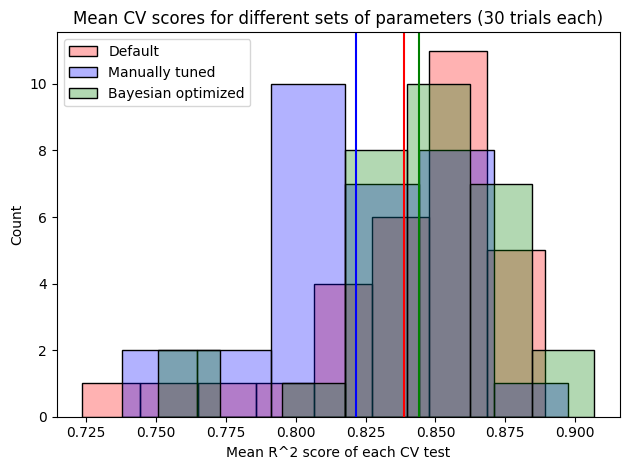

In [382]:
default = []
tuned = []
bayesian = []

for i in range(30) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    default.append(r2_score(y_test, y_pred))

    model = RandomForestRegressor(**manually_tuned_rf_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tuned.append(r2_score(y_test, y_pred))

    model = RandomForestRegressor(**bayes_rf_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bayesian.append(r2_score(y_test, y_pred))

default_rf = np.array(default)
tuned_rf = np.array(tuned)
bayesian_rf = np.array(bayesian)

sns.histplot(default_rf, alpha=0.3, color='red', bins='auto', label='Default')
sns.histplot(tuned_rf, alpha=0.3, color='blue', bins='auto', label='Manually tuned')
sns.histplot(bayesian_rf, alpha=0.3, color='green', bins='auto', label='Bayesian optimized')
plt.axvline(x=default_rf.mean(), color='red')
plt.axvline(x=tuned_rf.mean(), color='blue')
plt.axvline(x=bayesian_rf.mean(), color='green')
plt.legend()
plt.title('Mean CV scores for different sets of parameters (30 trials each)')
plt.xlabel('Mean R^2 score of each CV test')
plt.tight_layout()
plt.show()

"The problem" persists. RF does seem to be slightly better at handling it, though.

Conclusion
---

Based on the current data, the Random Forest model seems to perform the best.

However, underlying issues in the data must be solved before we can choose any model.